# 4. Evaluation Metrics for Classification

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# fix name of columns
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Get list of categorical type columns
categorical_columns = list(df.dtypes[df.dtypes.eq("object")].index)

for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

# Parse totalcharges to numeric and replace invalids with NAN
df["totalcharges"] = pd.to_numeric(df.totalcharges, errors="coerce").fillna(0)

# Parse yes to 1 no to 0
df["churn"] = df.churn.eq("yes").astype(int)

In [4]:
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=1,
)
df_train, df_val = train_test_split(
    df_full_train,
    test_size=(0.2 / 0.8),
    random_state=1,
)

# Reset index and get y vectors
target = "churn"

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

In [5]:
numerical = list(df_full_train.dtypes[df_full_train.dtypes.ne("object")].index)[1:-1]
print(numerical)
categorical = [col for col in list(df_full_train.dtypes.index) if col not in numerical][1:-1]
print(categorical)

['tenure', 'monthlycharges', 'totalcharges']
['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


In [6]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient="records")

# fit and transform
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.fit_transform(val_dicts)

# 1st column is prob for 0, 2nd for 1
y_pred = model.predict_proba(X_val)[:,1]

# People will churn if prob >= 0.5
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547


## 4.2 Accuracy and dummy model

[video](https://www.youtube.com/watch?v=FW_l7lB0HUI&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

**Accuracy** measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions. 

We can change the **decision threshold**, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the hightest accuracy (80%), was indeed 0.5. 

Note that if we build a **dummy model** in which the decision cutoff is 1, so the algorithm predicts that no clients will churn, the accuracy would be 73%. Thus, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect. 

Therefore, in this problem accuracy can not tell us how good is the model because the dataset is **unbalanced**, which means that there are more instances from one category than the other. This is also known as **class imbalance**. 

**Classes and methods:**

* `np.linspace(x,y,z)` - returns a numpy array starting at `x` until `y` with `z` evenly spaced samples 
* `Counter(x)` - collection class that counts the number of instances that satisfy the `x` condition
* `accuracy_score(x, y)` - sklearn.metrics class for calculating the accuracy of a model, given a predicted `x` dataset and a target `y` dataset. 

In [8]:
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [11]:
# Testing more thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    # churn_decision = (y_pred >= t)
    # score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= 0.5)
    print("%.2f => %.3f" % (t, score))
    scores.append(score)

0.00 => 0.803
0.05 => 0.803
0.10 => 0.803
0.15 => 0.803
0.20 => 0.803
0.25 => 0.803
0.30 => 0.803
0.35 => 0.803
0.40 => 0.803
0.45 => 0.803
0.50 => 0.803
0.55 => 0.803
0.60 => 0.803
0.65 => 0.803
0.70 => 0.803
0.75 => 0.803
0.80 => 0.803
0.85 => 0.803
0.90 => 0.803
0.95 => 0.803
1.00 => 0.803


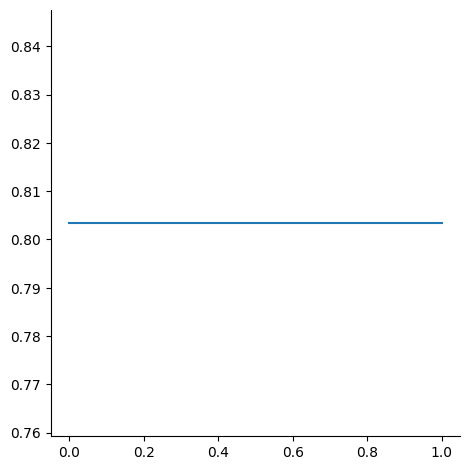

In [12]:
sns.relplot(x=thresholds, y=scores, kind="line");

In [13]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

## 4.3 Confusion table

[video](https://www.youtube.com/watch?v=Jt2dDLSlBng&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR)

[Slides](https://www.slideshare.net/AlexeyGrigorev/ml-zoomcamp-4-evaluation-metrics-for-classification)


## Notes

Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. Considering this information, it is possible to evaluate the quality of the model by different strategies.

When comes to a prediction of an LR model, each falls into one of four different categories:

* Prediction is that the customer WILL churn. This is known as the **Positive class**
    * And Customer actually churned - Known as a **True Positive (TP)**
    * But Customer actually did not churn - Knwon as a **False Positive (FP)**
* Prediction is that the customer WILL NOT churn' - This is known as the **Negative class**
    * Customer did not churn - **True Negative (TN)**
    * Customer churned - **False Negative (FN)**

'Confusion Table' is a way to summarize the above results in a tabular format, as shown below: 

|**Actual :arrow_down:     Predictions:arrow_right:**|**Negative**|**Positive**|
|:-:|---|---|
|**Negative**|TN|FP|
|**Postive**|FN|TP| 

The **accuracy** corresponds to the sum of TN and TP divided by the total of observations. 


In [14]:
actual_positive = y_val == 1
actual_negative = y_val == 0

In [15]:
predict_positive = y_pred >= 0.5
predict_negative = y_pred < 0.5

In [16]:
print(actual_positive.sum())
print(actual_negative.sum())
print(predict_positive.sum())
print(predict_negative.sum())

386
1023
311
1098


In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
tp, tn


(210, 922)

In [18]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
fp, fn

(101, 176)

In [19]:
[[tn, fp],
 [fn, tp]]

[[922, 101], [176, 210]]